# TD Learning: SARSA e *Q*-learning

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

Objetivo: ensinar um robô a navegar através de um labirinto até um ponto-alvo específico.

<img src="problema_labirinto.png" width="300">

## Características do labirinto:

### Espaço de observações

O labirinto corresponde a um espaço de 10x10 metros, discretizado em um grid de 25x25.

### Espaço de ações

O robô pode dar um passo em todas as 8 direções (todos os vizinhos são alcançáveis), ou pode ficar parado.

### Função de recompensa

- Se alcançar o objetivo, recebe +100
- Se o número de passo exceder 100, recebe -20
- Se o robô colidir com algum obstáculo, recebe -50

In [1]:
import class_maze as cm
import numpy as np
from functools import partial
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)

Criando a classe para o TD learning.

In [2]:
class TDlearning(object):
    def __init__(self, parameters):

        self.parameters = parameters

        # metodo
        self.method = parameters['method']

        # numero de episodios
        self.episode = 0

        # cria o ambiente
        self.env = cm.Maze(render=parameters['render'])

        # tamanho dos espacos de estados e acoes
        self.num_states = np.prod(np.array(self.env.num_states))
        self.num_actions = self.env.action_space.n

        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.eps = parameters['eps']
        self.alpha = parameters['alpha']

        # log file (nome depende do metodo)
        self.logfile = parameters['q-file']
        if self.method == 'SARSA':
            self.logfile = 'sarsa_' + self.logfile
        elif self.method == 'Q-learning':
            self.logfile = 'qlearning_' + self.logfile
        else: print("Não salvou...")

        # reseta a politica
        self.reset()

    ##########################################
    # reseta a funcao acao-valor
    def reset(self):
        # reseta o ambiente
        S = self.env.reset()
        
        # Q(s,a)
        self.Q = np.zeros((self.num_states, self.num_actions))

        # carrega tabela pre-computada se for o caso
        if self.parameters['load_Q']:
            try:
                with open(self.logfile, 'rb') as f:
                    data = np.load(f)
                    self.Q = data['Q']
                    self.episode = data['episodes']
            except: None

    ##########################################
    # retorna a politica corrente
    def curr_policy(self, copy=False):
        if copy:
            return partial(self.TabularEpsilonSoftPolicy, np.copy(self.Q))
        else:
            return partial(self.TabularEpsilonSoftPolicy, self.Q)
        
    ########################################
    # salva tabela Q(s,a)
    def save(self):
        with open(self.logfile, 'wb') as f:
            np.savez(f, Q=self.Q, episodes=self.episode)

    ##########################################
    def __del__(self):
        self.env.close()

Probabilidade de escolha de uma ação $a$ baseada na política $\varepsilon$-soft:
$$
\pi(a|S_t) \gets 
                        \begin{cases}
                            1 - \varepsilon + \varepsilon/|\mathcal{A}|,  & \text{se}~ a = \arg\max\limits_{a} Q(S_t,a),\\
                            \varepsilon/|\mathcal{A}|, & \text{caso contrário.}
                        \end{cases}
$$

In [3]:
class TDlearning(TDlearning):
    ##########################################
    # escolha da açao (epsilon-soft)
    def TabularEpsilonSoftPolicy(self, Q, state):
        # probabilidades de escolher as acoes
        p1 = 1.0 - self.eps + self.eps/self.num_actions
        p2 = self.eps/self.num_actions
        prob = [p1 if a == Q[state, :].argmax() else p2 for a in range(self.num_actions)]
        
        return np.random.choice(self.num_actions, p=np.array(prob))

Método do SARSA:
- aplique ação $A$, receba $S'$ e $R$
- escolha $A'$ a partir de $S'$ usando $Q$ ($\varepsilon$-greedy, por exemplo)
- $Q(S,A) \gets Q(S,A) + \alpha \big[R + \gamma Q(S',A') - Q(S,A)\big]$
- $S \gets S'$
- $A \gets A'$

In [4]:
class TDlearning(TDlearning):
    ##########################################
    def sarsa(self, S, A):

        # passo de interacao com o ambiente
        [Sl, R, done, _] = self.env.step(A)
        
        # escolhe A' a partir de S'
        Al = self.policy(Sl)
        
        # update de Q(s,a)
        self.Q[S, A] = self.Q[S, A] + self.alpha*(R + self.gamma*self.Q[Sl, Al] - self.Q[S, A])
        
        return Sl, Al, R, done

Método do *Q*-learning:
- escolha $A$ a partir de $S$ usando $Q$ ($\varepsilon$-greedy, por exemplo)
- aplique ação $A$, receba $S'$ e $R$
- $Q(S,A) \gets Q(S,A) + \alpha \big[R + \gamma \max\limits_a Q(S',a) - Q(S,A)\big]$
- $S \gets S'$

In [5]:
class TDlearning(TDlearning):
    ##########################################
    def qlearning(self, S):
        
        # \pi(s)
        A = self.policy(S)

        # passo de interacao com o ambiente
        [Sl, R, done, _] = self.env.step(A)
        
        self.Q[S, A] = self.Q[S, A] + self.alpha*(R + self.gamma*self.Q[Sl, :].max() - self.Q[S, A])
        
        return Sl, R, done

Executando um episódio.

In [6]:
class TDlearning(TDlearning):
    ##########################################
    def runEpisode(self, render_every=100):

        # novo episodio
        self.episode += 1

        # pega a politica corrente (on-policy)
        self.policy = self.curr_policy()
        
        # inicia o ambiente (começa aleatoriamente)
        S = self.env.reset()
        
        # \pi(s)
        A = self.policy(S)

        # lista de rewards
        rewards = []

        while True:
            # SARSA
            if self.method == 'SARSA':
                Sl, Al, R, done = self.sarsa(S, A)
                # proxima ação
                A = Al
            # Q-learning
            elif self.method == 'Q-learning':
                Sl, R, done = self.qlearning(S)
            else:
                print('Método errado.')
            
            # proximo estado
            S = Sl

            # Salva rewards
            rewards.append(R)

            # renderiza o ambiente
            if (self.episode-1)%render_every == 0:
                self.env.render(self.Q)

            # chegou a um estado terminal?
            if done: break
        
        # salva a tabela Q
        if self.parameters['save_Q']:
            self.save()

        return np.sum(np.array(rewards))

Código principal:
- episodes: número de episódios
- max_steps: número máximo de passos no episódio
- gamma: fator de desconto
- eps: $\varepsilon$
- alpha: $\alpha$
- method: *SARSA* ou *Q-learning*
- render: renderiza animação
- save_Q: salva tabela *Q*
- load_Q: carrega tabela *Q*
- q-file: arquivo da tabela *Q*

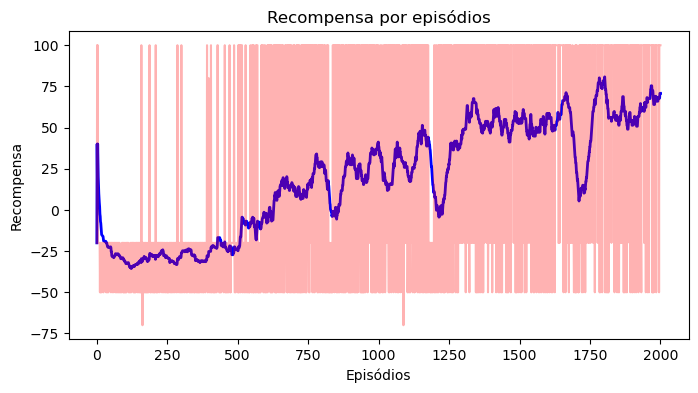

In [7]:
if __name__ == '__main__':
    
    plt.ion()

    # parametros
    parameters = {'episodes'  : 2000,
                  'gamma'     : 0.99,
                  'eps'       : 1.0e-1,
                  'alpha'     : 0.5,
                  'method'    : 'Q-learning', #'SARSA' ou 'Q-learning'
                  'render'    : True,
                  'save_Q'    : True,
                  'load_Q'    : False,
                  'q-file'    : 'qtable.npy',}

    # TD algorithm
    mc = TDlearning(parameters)

    # historico de recompensas
    rewards = []
    avg_rewards = []
    
    while mc.episode <= parameters['episodes']:
        # roda um episodio
        total_reward = mc.runEpisode()
        
        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_rewards.append(np.mean(rewards[-50:]))
        
        # plot rewards
        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        plt.title('Recompensa por episódios')
        plt.xlabel('Episódios')
        plt.ylabel('Recompensa')
        plt.show()
        plt.pause(.1)